In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('spam.csv')

df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [4]:
display(df["Class"].value_counts())

df['Class'].value_counts() / len(df)

Class
ham     4827
spam     747
Name: count, dtype: int64

Class
ham     0.865985
spam    0.134015
Name: count, dtype: float64

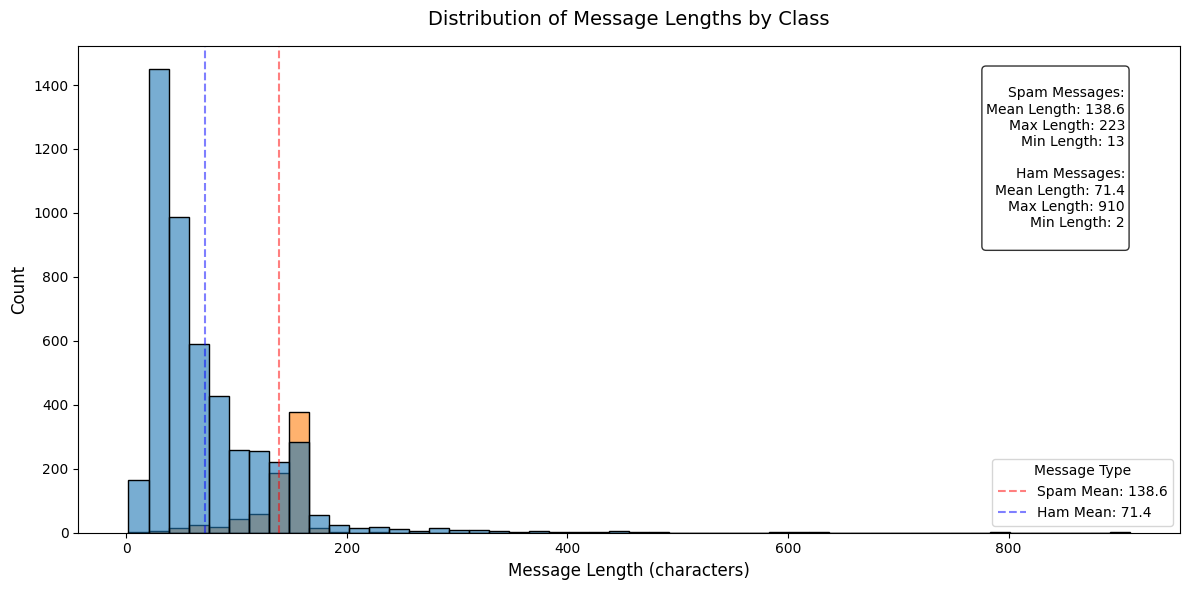

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# We will try to visualize the distribution of lengths of spam and ham messages

# Let's calculate the length of each message
df['length'] = df['Message'].str.len()

# Create two separate length distributions
spam_lengths = df[df['Class'] == 'spam']['length']
ham_lengths = df[df['Class'] == 'ham']['length']

# Set up the plot style
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='length', hue='Class', multiple="layer", 
             bins=50, alpha=0.6, legend=True)

plt.title('Distribution of Message Lengths by Class', fontsize=14, pad=15)
plt.xlabel('Message Length (characters)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add mean length lines
spam_mean = spam_lengths.mean()
ham_mean = ham_lengths.mean()

plt.axvline(spam_mean, color='red', linestyle='--', alpha=0.5, 
            label=f'Spam Mean: {spam_mean:.1f}')
plt.axvline(ham_mean, color='blue', linestyle='--', alpha=0.5, 
            label=f'Ham Mean: {ham_mean:.1f}')

# Adjust legend
plt.legend(title='Message Type')

# Add some statistics as text
stats_text = f"""
Spam Messages:
Mean Length: {spam_mean:.1f}
Max Length: {spam_lengths.max():.0f}
Min Length: {spam_lengths.min():.0f}

Ham Messages:
Mean Length: {ham_mean:.1f}
Max Length: {ham_lengths.max():.0f}
Min Length: {ham_lengths.min():.0f}
"""

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Show the plot
plt.show()

We notice that spam messages are on average longer than ham messages. However, the longest messages are still ham messages.

Now we will try to construct word clouds for spam and ham messages. This way we can see which words are more common in each type of message.

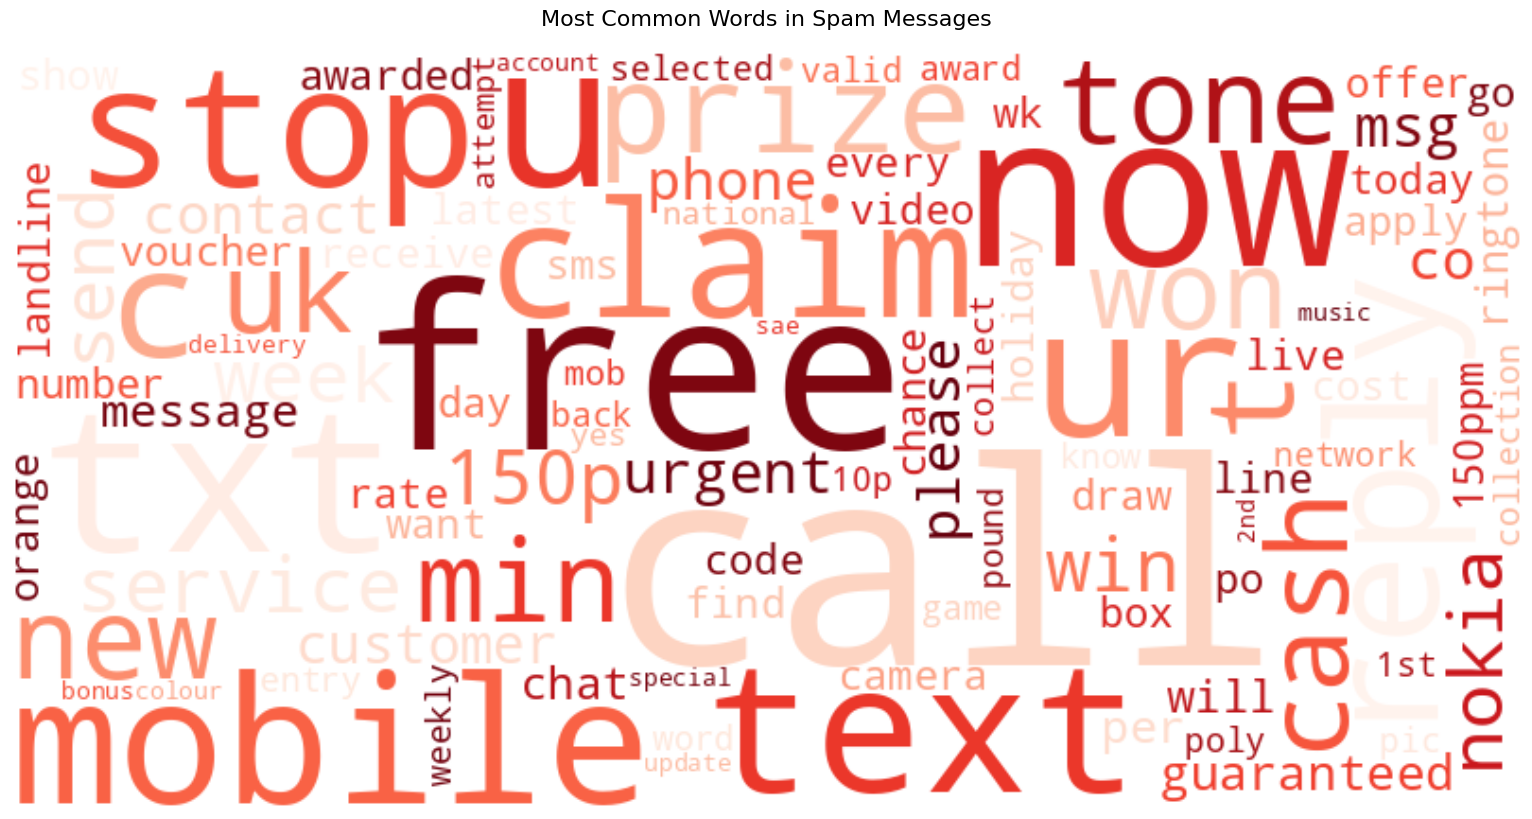

In [ ]:
# Combinining all the spam messages into a single string
spam_messages = ' '.join(df[df['Class'] == 'spam']['Message'])

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    colormap='Reds',  
    collocations=False,  
    min_font_size=10,
    max_font_size=150
).generate(spam_messages.lower()) 

# Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Most Common Words in Spam Messages', fontsize=16, pad=20)
plt.tight_layout(pad=0)
plt.show()

As expected the most common words in spam messages are words like call or free or claim. It makes sense as these messages are trying to bait people into something

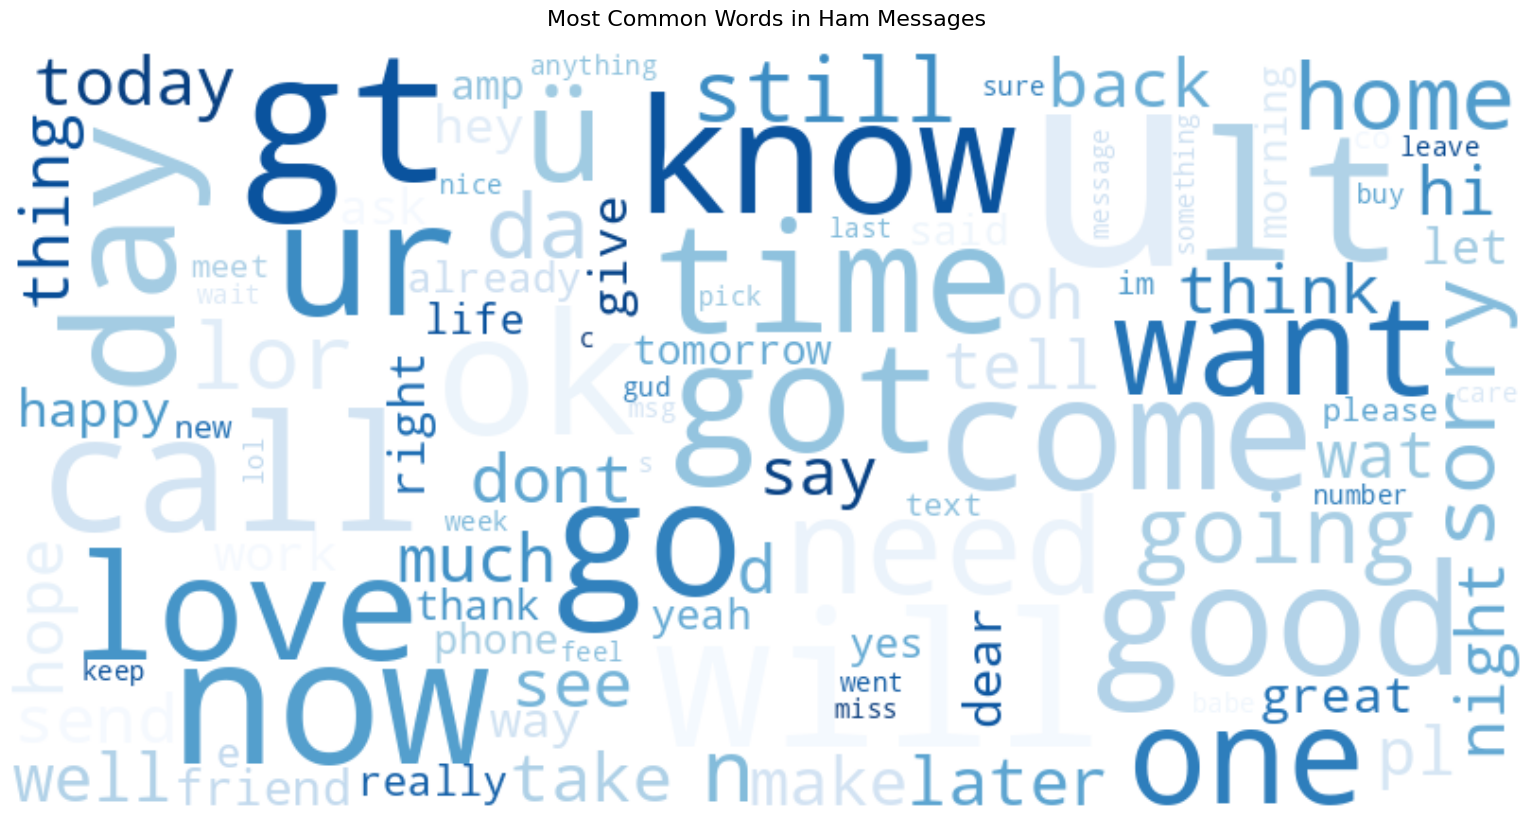

In [17]:
# Combining all ham messages into one string
ham_messages = ' '.join(df[df['Class'] == 'ham']['Message'])

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    colormap='Blues',  
    collocations=False,  
    min_font_size=10,
    max_font_size=150
).generate(ham_messages.lower())  

# Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Most Common Words in Ham Messages', fontsize=16, pad=20)
plt.tight_layout(pad=0)
plt.show()

On the other hand the most common words in normal messages are words like love or go or want. Normal words people would use in conversations.

We can easily see that there is huge class imbalance in dataset, with only 13% of samples having spam label

In [4]:
# lets convert the labels to 0 and 1 instead of strings
y = df['Class'].map({'ham': 0, 'spam': 1}).values
y

array([0, 0, 1, ..., 0, 0, 0])

In [5]:
X = df['Message'].values


In [6]:
train_split =0.64
val_split = 0.16
test_split = 0.2

In [7]:
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=val_split/(val_split + train_split), random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3567,) (892,) (1115,)


In [8]:
# because rnn expects fixed length input, we need to pad the sequences, we will pad them to the length of the longest sequence
max_word_sample = max([len(x.split()) for x in X_train])

max_word_sample

171

In [ ]:
# text vectorizer, that splits the text into words and converts them to integers
# to decrease overfitting we limit dictionary size to 5000
# also we standardize the text by lowercasing
# we were also experimenting with removing punctuation, however as the data is from sms messages,
# there are a lot of emojis made from punctuation, so we decided to keep them, because the they probably carry some meaning
word_vectorizer = tf.keras.layers.TextVectorization(split='whitespace', standardize='lower', max_tokens=5000, output_sequence_length=max_word_sample)
word_vectorizer.adapt(X_train)

In [10]:
n_tokens = word_vectorizer.vocabulary_size()
n_tokens

5000

In [11]:
# vectorize the text
X_train_word = word_vectorizer(X_train)
X_val_word = word_vectorizer(X_val)
X_test_word = word_vectorizer(X_test)


In [ ]:
# as rnn cells expect the sequences of the same length, we need to pad them
# we pad them to the length of the longest sequence in dataset
# we use 'post' padding, so adding padding to the end of the sequence
# because only this padding can be used with GPU acceleration
X_train_word = tf.keras.preprocessing.sequence.pad_sequences(X_train_word, padding='post', maxlen=max_word_sample)
X_val_word = tf.keras.preprocessing.sequence.pad_sequences(X_val_word, padding='post', maxlen=max_word_sample)
X_test_word = tf.keras.preprocessing.sequence.pad_sequences(X_test_word, padding='post', maxlen=max_word_sample)

In [13]:
X_train_word.shape

(3567, 171)

In [ ]:
batch_size = 128
model_word = tf.keras.Sequential([
    # embedding layer that transforms the integer representation of the words to learnable dense vectors
    # we mask the padding tokens, because they are not part of the sequence and we don't want to learn anything from them
  layers.Embedding(input_dim=n_tokens, output_dim=64, mask_zero=True),
    # simple rnn model
    # it is binary classification problem, so we use sigmoid activation function
  layers.LSTM(32),
  layers.Dense(1, activation='sigmoid')
])


In [15]:
# following model from lesson with use Adam with nesterov trick
# the sample size is not quite big and the model learns very fast, so we use 0.001 lr
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

# because there is huge class imbalance, the accuracy is not a good metric, because we can easily get high accuracy by predicting the majority class
# instead we use precision and recall as metrics
# precision is probably the most important metric, because we don't want to classify good messages as spam, as they would go to spam folder, and the user would not see them
# recall is also important, as we would like to be able to catch as many spam messages as possible, decreasing the chance that user clicks on spam message (usually a scam)
model_word.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['precision', 'recall'])

epochs = 40
# standard callbacks like reduce lr on plateau and early stopping
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

model_word.fit(X_train_word, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_word, y_val), callbacks = [es, lr])

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.6122 - precision: 0.1895 - recall: 0.0630 - val_loss: 0.3459 - val_precision: 1.0000 - val_recall: 0.0439 - learning_rate: 0.0010
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2586 - precision: 0.9993 - recall: 0.3590 - val_loss: 0.1351 - val_precision: 0.8661 - val_recall: 0.8509 - learning_rate: 0.0010
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0992 - precision: 0.9357 - recall: 0.8808 - val_loss: 0.1133 - val_precision: 0.9118 - val_recall: 0.8158 - learning_rate: 0.0010
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0688 - precision: 0.9739 - recall: 0.9013 - val_loss: 0.0818 - val_precision: 0.8966 - val_recall: 0.9123 - learning_rate: 0.0010
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0425 - precision: 0.9861 - recall: 0.9496 - val_loss: 0.0797 - val_precision: 0.9035 - val_recall: 0.9035 - learning_rate: 0.0010
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms

In [16]:
model_word.evaluate(X_test_word, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - precision: 0.9945 - recall: 0.9376


[0.05608553811907768, 0.9864864945411682, 0.9068322777748108]

The model stopped after 15 epochs as it was very easy task for it. After evalution on test set, we see that the model achieves 94% precision and 95% recall. This are very good results, because usually being good in one of these metrics means being bad in the other.

Now let's see if we can replicate these results using model that does vectorization per character instead of per word. On the first glance, it seems like it will be much harder to train it, but maybe the results will be even better.

In [17]:
# vectorizer that splits the text into characters
char_vectorizer = tf.keras.layers.TextVectorization(split='character', standardize='lower')
char_vectorizer.adapt(X_train)

n_tokens = char_vectorizer.vocabulary_size()
n_tokens


82

Compared to word vectorizer our dictionary becomes much smaller from 5000 to just 82 tokens.


In [18]:
# we compute max sequence length for the character model
max_chars_sample = max([len(x) for x in X_train])
max_chars_sample

910

In [19]:
# vectorizing the text
X_train_char = char_vectorizer(X_train)
X_val_char = char_vectorizer(X_val)
X_test_char = char_vectorizer(X_test)

In [ ]:
# padding the sequences
X_train_char = tf.keras.preprocessing.sequence.pad_sequences(X_train_char, padding='post', maxlen=max_chars_sample)
X_val_char = tf.keras.preprocessing.sequence.pad_sequences(X_val_char, padding='post', maxlen=max_chars_sample)
X_test_char = tf.keras.preprocessing.sequence.pad_sequences(X_test_char, padding='post', maxlen=max_chars_sample)

In [ ]:
# as expected it was much harder to find a stable training for the character model
# we found that decreasing batch size, learning rate and adding dropout layers helpes
# also we added fully connected ReLU layer before the output layer
# but probably the most important thing was to use bidirectional LSTMs
# biredirectional RNN process sequence from both ends, so they can learn more context
# also our first RNN layer returns sequence so that the second layer has access to entire sequence (information)
batch_size = 32
char_embedding_layer = layers.Embedding(input_dim=n_tokens, output_dim=32, mask_zero=True)
char_rnn = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),  
    layers.Dropout(0.3),  
    layers.Bidirectional(layers.LSTM(32)),  
    layers.Dropout(0.3),  
    layers.Dense(16, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])

model_char = tf.keras.Sequential([
    char_embedding_layer,
    char_rnn
])
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
# because the model is quite unstable at the beginning, we use a little bit longer patience
es = tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True)


# we also experimentally found out at normal Adam optimizer works better than Nadam for us
char_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_char.compile(loss="binary_crossentropy", optimizer=char_optimizer, metrics=['precision', 'recall'])

model_char.fit(X_train_char, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_char, y_val), callbacks = [es, lr], shuffle= True)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_5' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.5240 - precision: 0.2936 - recall: 0.0708 - val_loss: 0.1925 - val_precision: 0.9714 - val_recall: 0.5965 - learning_rate: 5.0000e-04
Epoch 2/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1614 - precision: 0.9390 - recall: 0.7185 - val_loss: 0.1258 - val_precision: 0.8268 - val_recall: 0.9211 - learning_rate: 5.0000e-04
Epoch 3/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0966 - precision: 0.8987 - recall: 0.9049 - val_loss: 0.1038 - val_precision: 0.9327 - val_recall: 0.8509 - learning_rate: 5.0000e-04
Epoch 4/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0825 - precision: 0.9552 - recall: 0.8855 - val_loss: 0.0876 - val_precision: 0.9528 - val_recall: 0.8860 - learning_rate: 5.0000e-04
Epoch 5/40
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0750 - precision: 0.9321 - recall: 0.9141 - val_loss: 0.1066 - val_precision: 0.9785 - val_recall: 0.7982 - learning_rate: 5.0000e-04
Epoch 6/40
112/112 ━━━━━━

In [25]:
model_char.evaluate(X_test_char, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0389 - precision: 0.9779 - recall: 0.9640


[0.05530751124024391, 0.949999988079071, 0.9440993666648865]

We achieve 98% precision and 97% recall on test set, which is even better than previous word model. This are great results in our opinion, granted this model was much more tuned and we spent mode time on it then on the word model. The word model also trained much faster as there were much less tokens to process.